## Introduction

Solve cart-pole problem using open-AI gym environment.


## Objectives


* Use the [OpenAI Gym](https://gym.openai.com/) reinforcement learning environments.
* Solve the classic reinforcement learning problem of balancing a pole on a moving cart using Random Search and Policy Gradients. Understand some of the limitations of these methods.

## Imports

In [3]:



# Note: enviroments like CartPole-v0 require a display to render. We need to install pyvirtualdisplay etc 
# in order to render from these environments

!pip install pyglet~=1.3.2 > /dev/null 2>&1
!pip install 'gym[atari]' > /dev/null 2>&1
!apt-get install python-opengl -y > /dev/null 2>&1
!apt install xvfb -y > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install tensorflow==2.0.0-beta0 > /dev/null 2>&1

from IPython.display import HTML

# Start virtual display
from pprint import pprint
import logging
from pyvirtualdisplay import Display
logging.getLogger("pyvirtualdisplay").setLevel(logging.ERROR)

display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display._obj._screen)

## The Reinforcement Learning Problem

So far we have encountered **supervised learning**, where we have an input and a target value or class that we want to predict. We have also encountered **unsupervised learning**, where we are only given an input and look for patterns in that input. In this practical, we look into **reinforcement learning**, which can loosely be defined as training an **agent** to maximise the total **reward** it obtains through many interactions with an **environment**.

At timestep $t$, the agent can make an **observation** of the environment $o_t$. For example, if the environment is a computer game, the observation could be the pixel values of the current screen.

The environment defines a set of **actions** that an agent can take.  The agent performs an action $a_t$ informed by the observations it has made, and will receive a **reward** $r_t$ from the environment after every action. The *reinforcement learning problem* is to find an agent whose actions maximize the total rewards obtained from the environment over many actions.

The following diagram illustrates the interaction between the agent and environment. We will explore each of the terms in more detail throughout this practical.

<!-- ![Interaction of Agent and Environment](https://github.com/sbodenstein/Tutorials/blob/master/indaba_2019/Images/RL_Environment.png?raw=true) -->

<img src="https://raw.githubusercontent.com/sbodenstein/Tutorials/master/indaba_2019/Images/RL_Environment.png" alt="drawing" width=600/>



### The Environment

We will focus on the cartpole environment for this practical. This environment consists of a pole attached to a cart via a hinge, with the pole initially balanced close to upright. The agent needs to move the cart to the left or to the right in order to prevent the pole from falling over.

![CartPole Illustration](https://user-images.githubusercontent.com/10624937/42135683-dde5c6f0-7d13-11e8-90b1-8770df3e40cf.gif)


In [4]:
import numpy as np
import gym
env_cartpole = gym.make('CartPole-v1')

The first step to using a Gym environment is to initialize the environment to some initial configuration using the `reset` method. The `reset` method also returns the first observation of the environment:

In [5]:
env_cartpole.reset()

array([-0.004087  ,  0.0215506 , -0.00598183, -0.00595498])

These four numbers represent the position and velocity of the cart and pole, `(cart position, cart velocity, pole angle, velocity of the top of the pole)`. We will want our agent to use this observation when deciding to move left or right. 

We also want to see an image of the system that we can interpret. Gym provides the `render` method to do this:

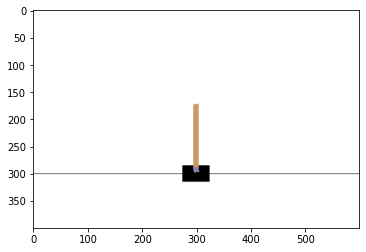

In [6]:
import matplotlib.pyplot as plt
plt.imshow(env_cartpole.render(mode='rgb_array'));

Note that reinitializing this environment with `reset` will randomly change the starting angle of the pole. By running this multiple times, see if you can notice this:

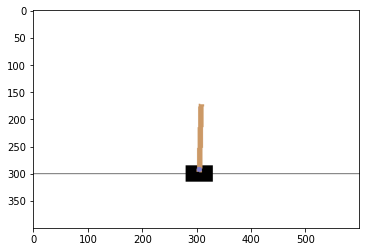

In [7]:
env_cartpole.reset()
plt.imshow(env_cartpole.render(mode='rgb_array'));

Now we want to take an action using the `step` method. But which actions are allowed, and how are they represented? We can find this out using the `action_space` property of Gym environments:

In [8]:
env_cartpole.action_space

Discrete(2)

In Gym, `Discrete(n)` means actions are represented by the integers `0,1,...,n-1`. Action spaces always provide a way to take a random action sampled from the space:

In [9]:
[env_cartpole.action_space.sample() for _ in range(10)]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1]

Now let us take an action using the `step` method, which takes an action and returns a tuple `(observation, reward, done, info)`:

In [10]:
action = 1
env_cartpole.step(action)

(array([ 0.04368524,  0.19472811,  0.02711837, -0.24813464]), 1.0, False, {})

In [11]:
env_cartpole._max_episode_steps

500

In [12]:
def agent_left(observation):
    return {"Action":0}

In [13]:
agent_left(None)

{'Action': 0}

This is called the **return**, $R$, and there are different ways of defining it. The most obvious definition for return is to simply add up all the rewards the agent received during an episode. If the episode took $T$ steps, and got a reward $r_t$ at each step, then this return is $R = \sum_{t=1}^{T} r_{t}$, where $r_t$ is the reward received at timestep $t$.

One issue is that some environments will have different initial states, agents may take actions stochastically and the rewards themselves could be stochastic. The solution is to average the returns over multiple starting points. Here is a function that does this:

In [14]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=500):
    episode_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        episode_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(episode_rewards), 
        "StandardDeviation":np.sqrt(np.var(episode_rewards))
    }

Now we can see how good our agent `agent_left` is:

In [15]:
average_episodic_return(env_cartpole, agent_left)

{'AverageEpisodicReturn': 9.5, 'StandardDeviation': 0.5}

## Animating Agents

This code cell defines a function `animate_agent(environment, agent)` that produces a human understandable animation of the `agent` controlling the `environment`. **Note:** It is not necessary to understand these functions to follow this practical.

In [16]:
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

Now we can easily get an animation of the cartpole environment controlled by `policy_left`:

In [17]:
def agent_left(observation):
    return {"Action":0}
  
animate_agent(env_cartpole, agent_left)

## Agent 1: Random Action Agent

In [18]:
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

In [19]:
average_episodic_return(env_cartpole, agent_random)

{'AverageEpisodicReturn': 21.4, 'StandardDeviation': 8.8}

And animating it:

In [20]:
animate_agent(env_cartpole, agent_random)

## Agent 2: Neural Net Policy Trained with Random Search

To improve on the random agent `agent_random`, we need a policy that takes the observation of the environment into account. In this section, we will show how to create an agent that solves the cartpole problem without any fancy reinforcement learning methods.



In [21]:
class AgentMLPNumpy:
    def __init__(self, num_hidden):
        self.W1 = np.random.randn(num_hidden, 4)
        self.W2 = np.random.randn(2, num_hidden)
        
    def __call__(self, x):
        y = self.W1.dot(x)
        y = np.tanh(y)
        y = self.W2.dot(y)
        return {"Action":np.argmax(y)}

The reate an instance of `AgentMLPNumpy` (with random weight initializations), and compute its return. If the return is better than previous agents, then keep this agent. Otherwise, throw it away and try a new randomly initialized agent `AgentMLPNumpy`. Repeat this process `n` times.

## Agent 3: Neural Net Agent Trained with Policy Gradients

### Episode Trajectory Collector

Let us implement a function `get_episode_trajectory(env, agent)` that controls the environment `env` with `agent` and returns lists of rewards, observations and actions taken at each timestep:

In [30]:
def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []

    done = False
    obs = env.reset()
    for _ in range(max_steps):
        observation_list.append(obs)
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]        
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action)
        if "Value" in out:
            value_list.append(out["Value"])
            
        if done:
            break
        
    ret = {
        "Observations": observation_list, 
        "Actions": action_list, 
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list
        
    return ret

Let us try out `get_episode_trajectory` on cartpole using the random agent we implemented earlier:

In [31]:
traj = get_episode_trajectory(env_cartpole, agent_random, max_steps=3)
pprint(traj)

{'Actions': [0, 1, 1],
 'Observations': [array([-0.00542769,  0.00200056,  0.01104304, -0.01189167]),
                  array([-0.00538768, -0.19327801,  0.0108052 ,  0.28425491]),
                  array([-0.00925324,  0.00168818,  0.0164903 , -0.00500063])],
 'Rewards': array([1., 1., 1.], dtype=float32)}


### Reward-to-go $\hat{R}_t$

We need to compute the reward-to-go $\hat{R}_t= \sum_{t'=t}^{T} r_{t'}$. Here is a simple NumPy implementation:

In [32]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))

Checking that this works as expected:

In [33]:
reward_to_go([1, 1.2, 1])

array([3.2, 2.2, 1. ])

The estimator $\Phi_t \equiv \hat{R}_t= \sum_{t'=t}^{T} r_{t'}$ we used has a number of problems. For example, if we don't get to the end of an episode (as it takes too long and we stop sampling), or our task is not episodic, we will have incorrect estimates of the advantages of our states. One popular alternative that works around this difficulty is the GAE-Lamba estimator: 
 

### TensorFlow Policy Net

Let us use a neural net policy with parameters $\theta$, so we have $\pi_\theta(a|s) = NN(s; \theta)$, where $NN(s; \theta)$ is some potentially complex function represented by a neural network with parameters $\theta$:

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [35]:
class AgentMLPTF(Model):
  def __init__(self):
    super(AgentMLPTF, self).__init__()
    self.d1 = Dense(15, activation='tanh')
    self.d2 = Dense(2)

  def call(self, x):
    # 1. Define Policy
    batch = True
    if x.ndim == 1:
        batch = False
        x = np.expand_dims(x, axis=0)
    x = self.d1(x)
    action_logits = self.d2(x)
    
    # 2. Sample policy to get action
    action = tf.random.categorical(action_logits, 1)
    action = action.numpy().flatten()
    if not batch:
        action = np.asscalar(action)
        
    return {"Action":action, "LogProbability":action_logits}

In [36]:
agent_mlp_tf = AgentMLPTF()

In [37]:
obs = np.array([0.1,0.2,0.3,0.4])
agent_mlp_tf(obs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


{'Action': 1,
 'LogProbability': <tf.Tensor: id=55, shape=(1, 2), dtype=float64, numpy=array([[0.17609322, 0.21415541]])>}

We can also verify that this works on a batch of observations:


In [38]:
obs_batch = np.array([[0.1,0.2,0.3,0.4], [0.5,0.3,0.2,0.1]])
agent_mlp_tf(obs_batch)

{'Action': array([1, 0]),
 'LogProbability': <tf.Tensor: id=69, shape=(2, 2), dtype=float64, numpy=
 array([[ 0.17609322,  0.21415541],
        [-0.12941752,  0.0514191 ]])>}

### Train the Policy Net

Now we can put all the pieces together in the training loop. It simply collects a single trajectory and uses it to do a single gradient update of the agent:

In [40]:
def train_policy_grad(env, agent, num_epochs=300):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    log_reward = 0
    log_reward_list = []
    logging_period = 20
    
    for epoch in range(num_epochs):
        # get the training data
        traj = get_episode_trajectory(env, agent)
        obs = np.stack(traj["Observations"])
        rew = traj["Rewards"]
        actions = traj["Actions"]
        
        # compute 'reward-to-go'
        rew_2_go = reward_to_go(rew)
        
        # compute gradients + update weights
        with tf.GradientTape() as tape:
            logits = agent(obs)["LogProbability"]
            loss = loss_pg(actions, logits, rew_2_go)
            
        gradients = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        
        # log the reward
        log_reward += np.sum(rew)
        if (epoch % logging_period) == 0:
            template = 'Training Epoch {}, Averaged Return: {}'
            print(template.format(epoch, log_reward / logging_period))
            log_reward_list.append(log_reward / logging_period)
            log_reward = 0
       
    return (range(0, num_epochs, logging_period), log_reward_list)

Note that `train_policy_grad(env, agent)` takes a TensorFlow agent as input and mutates it during training. Create and train a `AgentMLPTF` agent:

In [41]:
agent_mlp_tf = AgentMLPTF()
(episodes, rewards) = train_policy_grad(env_cartpole, agent_mlp_tf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Training Epoch 0, Averaged Return: 0.95
Training Epoch 20, Averaged Return: 34.55
Training Epoch 40, Averaged Return: 51.95
Training Epoch 60, Averaged Return: 68.45
Training Epoch 80, Averaged Return: 74.55
Training Epoch 100, Averaged Return: 77.35
Training Epoch 120, Averaged Return: 68.8
Training Epoch 140, Averaged Return: 77.15
Training Epoch 160, Averaged Return: 84.5
Training Epoch 180, Averaged Return: 100.55
Training Epoch 200, Averaged Return: 113.95
Training Epoch 220, Averaged Return: 169.35
Training Epoch 240, Averaged Return: 130.25
Training Epoch 260, Averaged Return: 130.8
Training Epoch 280, Averaged Return: 252.05


**We can plot the average rewards obtained versus the number of episodes trained for:**

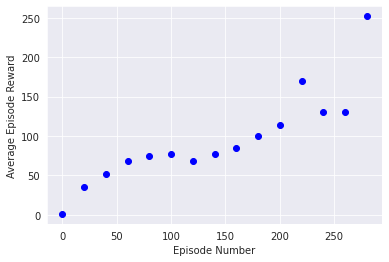

In [42]:
plt.plot(episodes, rewards, 'bo')
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.show()

**Results**

Let us animate this agent controlling the cartpole environment:

In [43]:
animate_agent(env_cartpole, agent_mlp_tf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
